In [1]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from dataset import LinearDynamicalDataset, WHDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from model import GPTConfig, GPT
import tqdm
import argparse

In [2]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [3]:
torch.manual_seed(420)
np.random.seed(430)

In [4]:
# Overall settings
out_dir = "../out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 32 # 256


# Compute settings
cuda_device = "cuda:1"
no_cuda = True
threads = 5
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [5]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_big_wh.pt", map_location=device)


In [6]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [7]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 85.74M


In [8]:
# Create data loader
#test_ds = LinearDynamicalDataset(nx=nx, nu=nu, ny=ny, seq_len=seq_len)
test_ds = WHDataset(nx=nx, nu=nu, ny=ny, seq_len=seq_len, system_seed=42, data_seed=None, fixed_system=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=threads)

In [9]:
batch_y, batch_u = next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
with torch.no_grad():
    batch_y_pred, loss = model(batch_u, batch_y)
    batch_y_pred = batch_y_pred.to("cpu").detach().numpy()
    batch_y = batch_y.to("cpu").detach().numpy()
    batch_u = batch_u.to("cpu").detach().numpy()

In [10]:
batch_y_target = batch_y[:, 1:, :] # target @ time k: y_{k+1}
batch_y_pred = batch_y_pred[:, :-1, :] # prediction @ time k: y_{k+1|k}
batch_y_pred_dummy = batch_y[:, :-1, :] # dummy estimator: y_{k+1} \approx y_{k}
batch_pred_err = batch_y_target - batch_y_pred
batch_pred_err_dummy = batch_y_target - batch_y_pred_dummy

In [11]:
#exp_data["LOSS_VAL"]

In [12]:
t = np.arange(1, batch_y.shape[1])

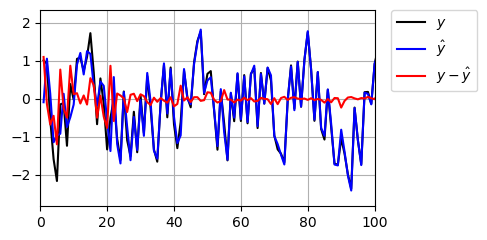

In [13]:
plt.figure(figsize=(5, 2.5))

idx = 7
plt.plot(t, batch_y_target[idx], 'k', label="$y$")
plt.plot(t, batch_y_pred[idx], 'b', label="$\hat y$")
#plt.plot(batch_y_pred_dummy[idx], 'm', label="Pred dummy")
plt.plot(t, batch_y_target[idx] - batch_y_pred[idx], 'r', label="$y - \hat y$")
#plt.plot(batch_y_target[idx] - batch_y_pred_dummy[idx], 'm', label="Err dummy")
#plt.legend(loc="upper right")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.xlim([0, 100]);
#plt.ylim([-3, 3]);
plt.tight_layout()
plt.savefig(fig_path / "wh_one_step_single.pdf")

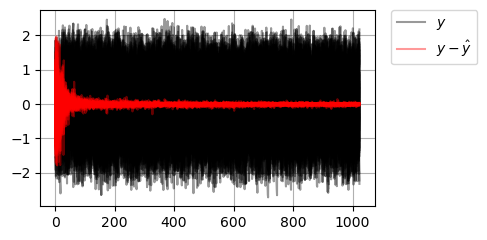

In [14]:
plt.figure(figsize=(5, 2.5))
#plt.title("Prediction error $y - \hat y$ on 256 sequences")
plt.plot(t, batch_y_target.squeeze(-1).T, "k", alpha=0.4);
plt.plot(t, batch_y_target.squeeze(-1).T[:, -1], "k", alpha=0.4, label="$y$")
plt.plot(t, batch_pred_err.squeeze(-1).T, "r", alpha=0.4);
plt.plot(t, batch_pred_err.squeeze(-1).T[:, -1], "r", alpha=0.4, label="$y - \hat y$");
plt.grid(True)
#plt.legend(loc="upper right")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(fig_path / "wh_one_step_batch.pdf")

In [15]:
from torchid import metrics
skip = 400
rmse_transformer = metrics.rmse(batch_y_target[:, skip:, :], batch_y_pred[:, skip:, :], time_axis=1)
rmse_dummy = metrics.rmse(batch_y_target[:, skip:, :], batch_y_pred_dummy[:, skip:, :], time_axis=1)

In [17]:
print(f"{rmse_transformer.mean()=:.2f}")

rmse_transformer.mean()=0.02
